<a href="https://colab.research.google.com/github/Yeonsu-Hong/Aiffel_Daegu_AI_project/blob/master/220314_exp_17_cGAN_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 17-13. 프로젝트 : Segmentation map으로 도로 이미지 만들기

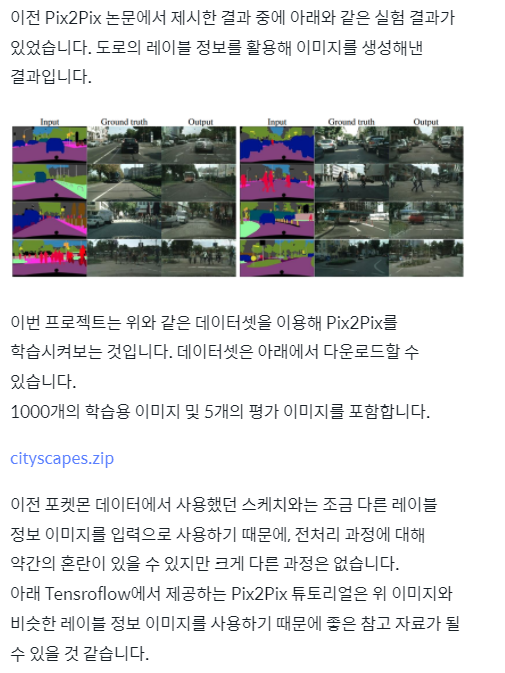

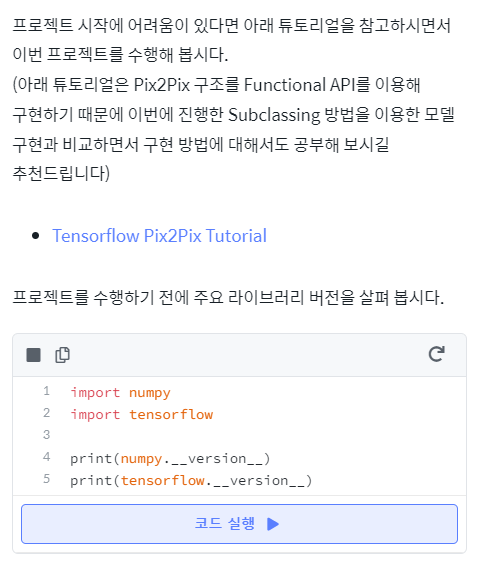

In [ ]:
import numpy as np
import tensorflow as tf

print(np.__version__)
print(tf.__version__)

1.21.5
2.8.0


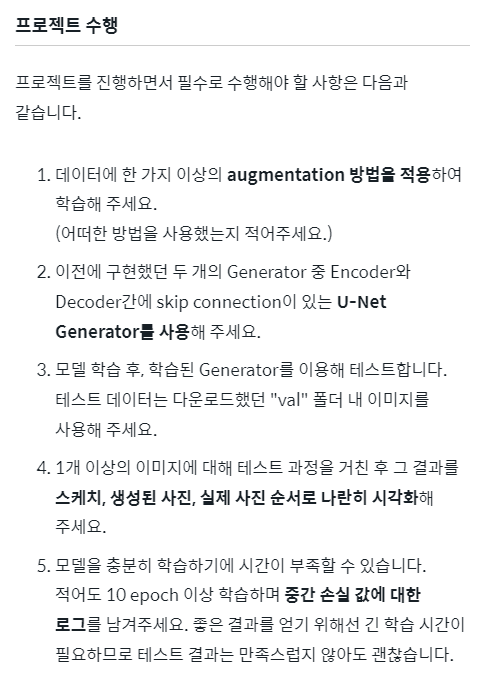

Custom Pixel Label Images (colored images)로 부터 이미지를 새롭게 생성하는 것이다. ground truth image는 실제로 쓰이는 단어로 실측 자료를 의미한다. 

정의 : 
현장에서 수행되는 다양한 형태의 측정과 관측을 통하여 획득되는 자료. 원격 탐사 영상의 해석, 판독 및 영상 분류 등의 작업을 확인할 수 있는 검증 자료로 사용된다.
(국방과학기술용어사전) 

아래에서는 ground image라는 약어로 사용한다.

In [7]:
# 대략적인 라이브러리 불러오기
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display


In [1]:
!mkdir -p ~/aiffel/conditional_generation/data

In [ ]:
# data는 수동으로 올림

In [2]:
!cd ~/aiffel/conditional_generation/data && unzip cityscapes.zip

Archive:  cityscapes.zip
   creating: cityscapes/
   creating: cityscapes/train/
  inflating: cityscapes/train/1.jpg  
  inflating: cityscapes/train/100.jpg  
  inflating: cityscapes/train/1000.jpg  
  inflating: cityscapes/train/101.jpg  
  inflating: cityscapes/train/102.jpg  
  inflating: cityscapes/train/106.jpg  
  inflating: cityscapes/train/109.jpg  
  inflating: cityscapes/train/112.jpg  
  inflating: cityscapes/train/113.jpg  
  inflating: cityscapes/train/114.jpg  
  inflating: cityscapes/train/116.jpg  
  inflating: cityscapes/train/119.jpg  
  inflating: cityscapes/train/12.jpg  
  inflating: cityscapes/train/124.jpg  
  inflating: cityscapes/train/128.jpg  
  inflating: cityscapes/train/135.jpg  
  inflating: cityscapes/train/137.jpg  
  inflating: cityscapes/train/139.jpg  
  inflating: cityscapes/train/140.jpg  
  inflating: cityscapes/train/144.jpg  
  inflating: cityscapes/train/148.jpg  
  inflating: cityscapes/train/153.jpg  
  inflating: cityscapes/train/154.jpg  
 

In [12]:
import os
import numpy as np

In [5]:
data_path = os.getenv("HOME")+'/aiffel/conditional_generation/data/cityscapes/train/'
print('number of train examples :', len(os.listdir(data_path)))

number of train examples : 1000


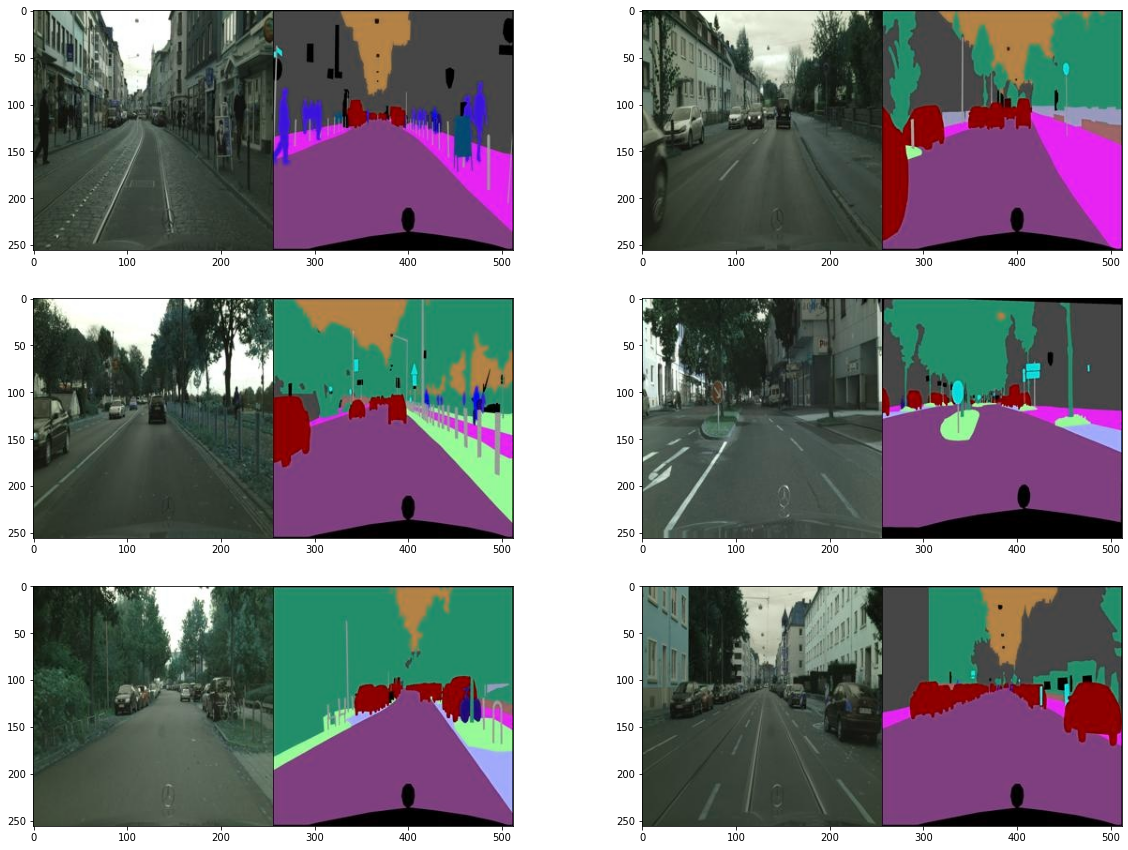

In [13]:
import cv2
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 15))
for i in range(1, 7):
  f = data_path + os.listdir(data_path)[np.random.randint(800)]
  img = cv2.imread(f, cv2.IMREAD_COLOR)
  plt.subplot(3,2,i)
  plt.imshow(img)

In [14]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


이미지의 크기는 (256, 512, 3)이다. color 이미지

Ground Truth (기준이 되는 원본 이미지)와 Input image 총 이미지 2개의 종류로 분할한다.

Text(0.5, 1.0, 'colored')

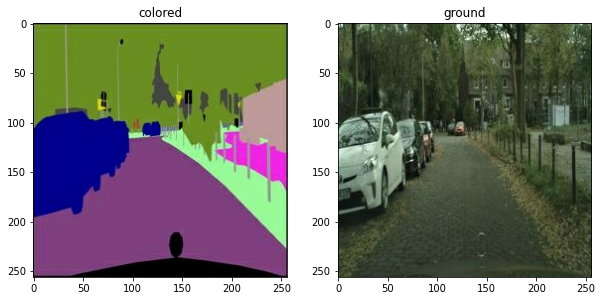

In [37]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    ground = img[:, :w, :] 
    ground = tf.cast(ground, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(ground), normalize(colored)

f = data_path + os.listdir(data_path)[1]
ground, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,2); plt.imshow(denormalize(ground)); plt.title('ground')
plt.subplot(1,2,1); plt.imshow(denormalize(colored)); plt.title('colored')

앞서 수행해야 할 사항 5가지가 있었다.

1. augmentation 방법을 적용하기
2. U-Net Generator를 사용
3. 모델 학습 후, 학습된 Generator를 이용해 테스트
4. 1개 이상의 이미지에 대해 테스트 과정을 거친후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화
5. 중간 손실값에 대한 로그를 남기기 (10 epoch이상 학습하며)

# 1. augmentation

In [38]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

In [39]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(ground, colored):
    stacked = tf.concat([ground, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out) # going deeper 3-5.에서 적용되었던 방법
    out = image.random_flip_up_down(out) # 역시 똑같다.
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

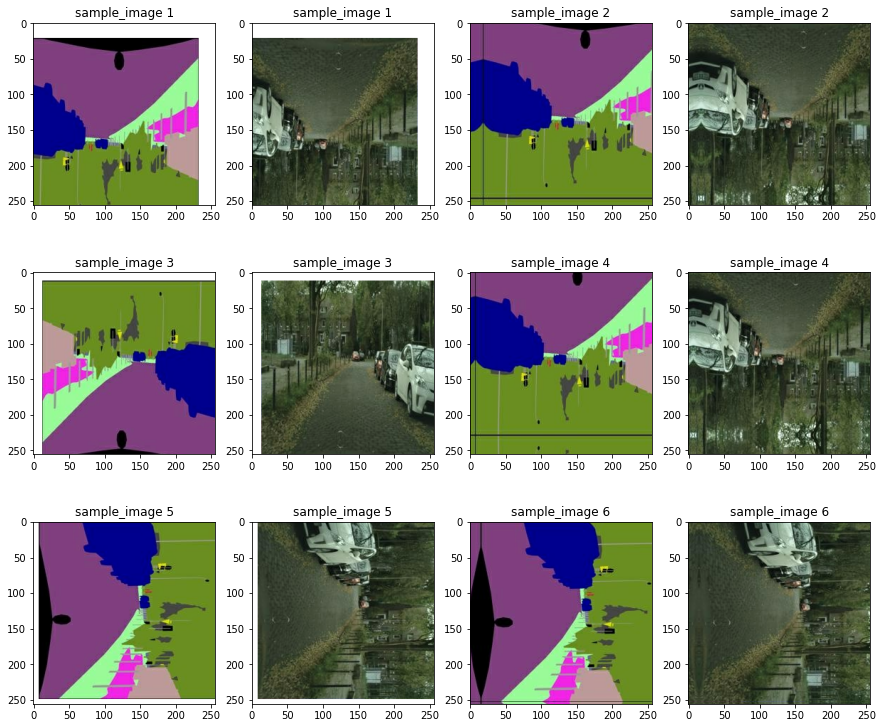

In [41]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_ground, augmented_colored = apply_augmentation(ground, colored)
    
    plt.subplot(3,4,i+1)
    plt.imshow(denormalize(augmented_ground)); plt.title(f"sample_image {img_n}")
    plt.subplot(3,4,i); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"sample_image {img_n}")
    img_n += 1

In [42]:
from tensorflow import data

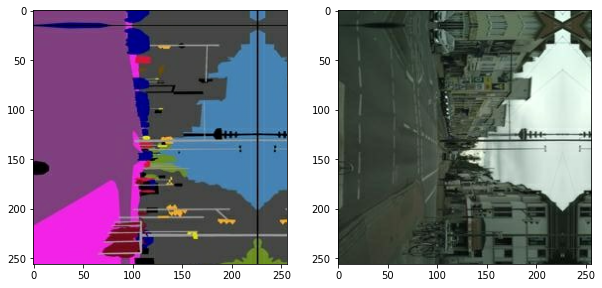

In [44]:
def get_train(img_path):
    ground, colored = load_img(img_path)
    ground, colored = apply_augmentation(ground, colored)
    return ground, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
ground, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,2); plt.imshow(ground[0].astype(np.uint8))
plt.subplot(1,2,1); plt.imshow(colored[0].astype(np.uint8))

# 2. U-Net Generator를 사용


In [45]:
from tensorflow.keras import layers, Input, Model

In [46]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [47]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [48]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

In [49]:
# Discriminator 구성

class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [50]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d_7 (ZeroPaddi  (None, 130, 130, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_55 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [51]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [52]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_52 (Concatenate)   (None, 256, 256, 6)  0           ['input_7[0][0]',                
                                                                  'input_8[0][0]']          

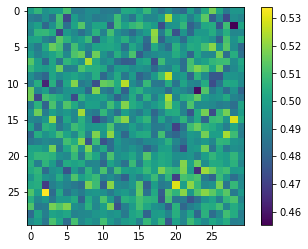

In [53]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [54]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [55]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [56]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [57]:
EPOCHS = 200

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (colored, predicted) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(colored, predicted)
                
        # 10회 반복마다 손실을 출력한다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
EPOCH[161] - STEP[10]                     
Generator_loss:0.8783                     
L1_loss:0.1213                     
Discriminator_loss:1.7142

EPOCH[161] - STEP[20]                     
Generator_loss:4.9288                     
L1_loss:0.1367                     
Discriminator_loss:1.2651

EPOCH[161] - STEP[30]                     
Generator_loss:3.0732                     
L1_loss:0.1192                     
Discriminator_loss:1.0063

EPOCH[161] - STEP[40]                     
Generator_loss:2.2984                     
L1_loss:0.1204                     
Discriminator_loss:0.3435

EPOCH[161] - STEP[50]                     
Generator_loss:2.6104                     
L1_loss:0.1301                     
Discriminator_loss:0.1635

EPOCH[161] - STEP[60]                     
Generator_loss:2.6993                     
L1_loss:0.1392                     
Discriminator_loss:0.1231

EPOCH[161] - STEP[70]                     
Generator_loss:3.3309      

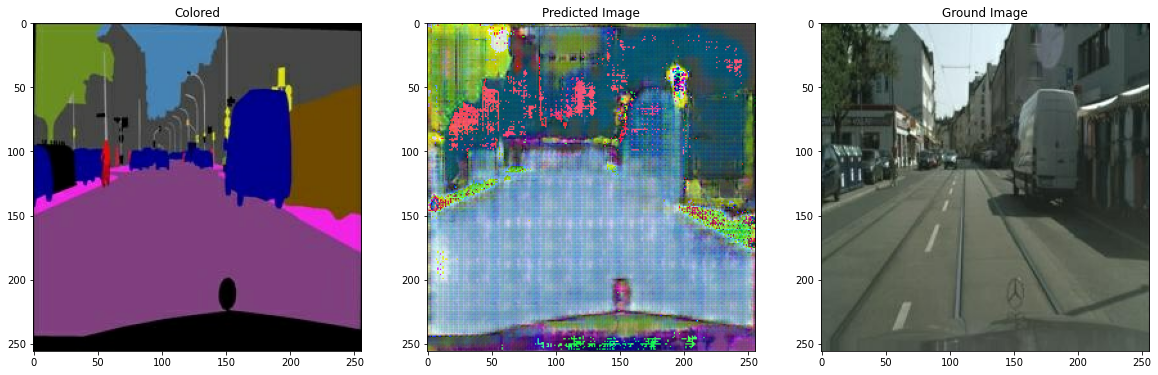

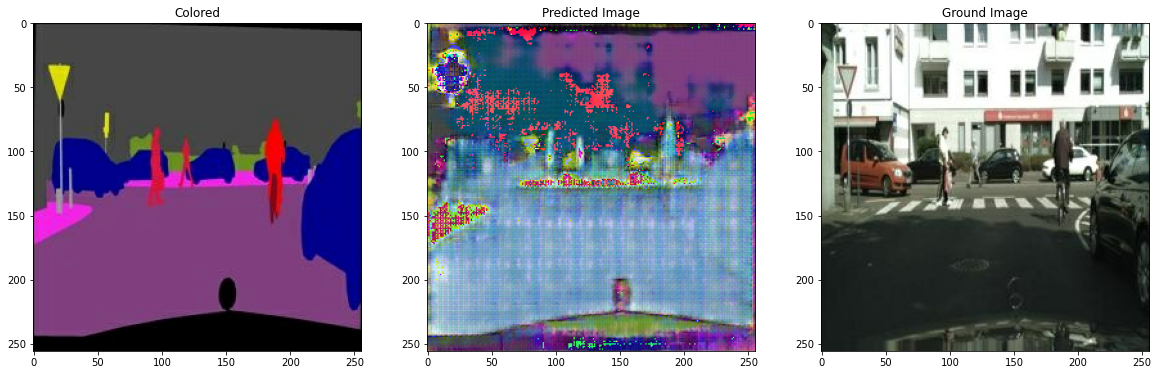

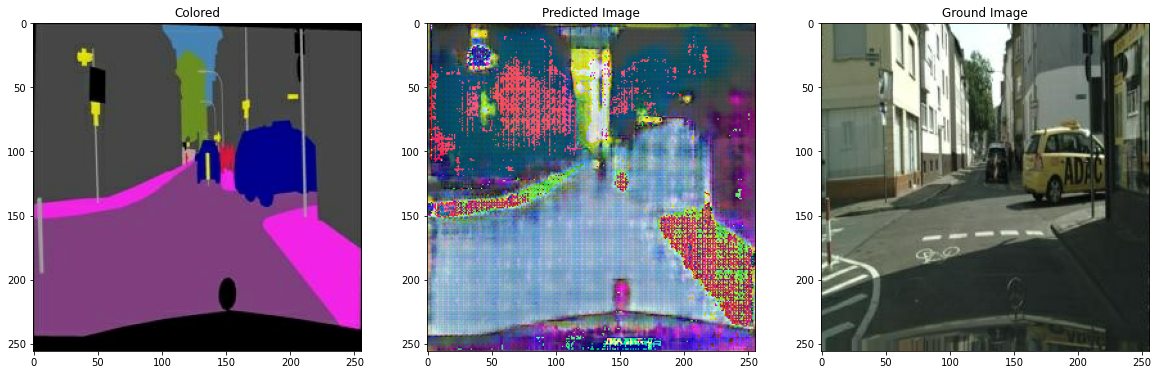

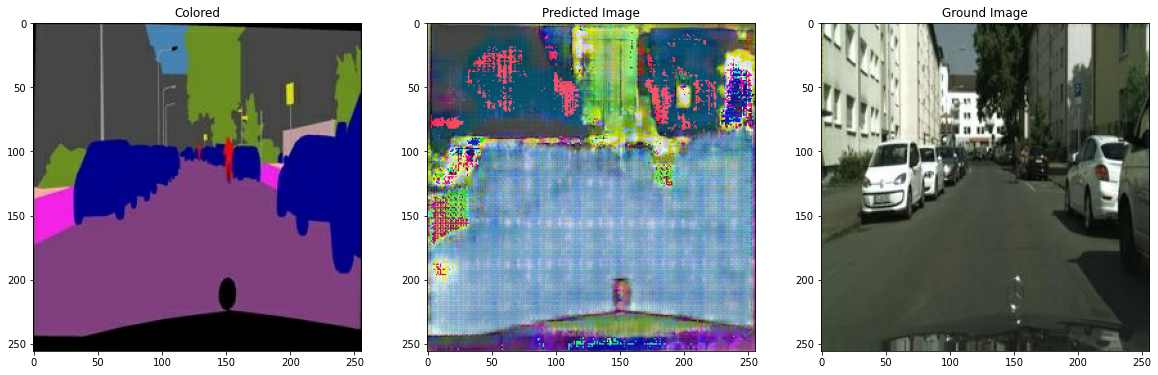

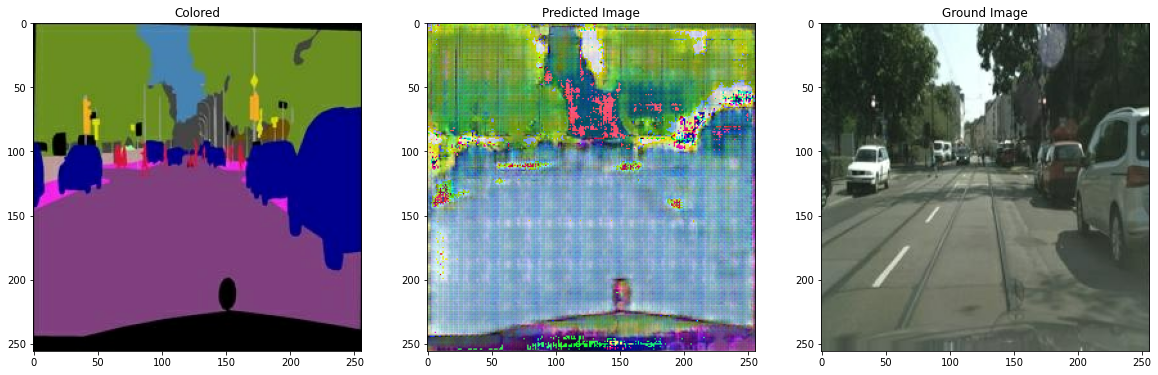

In [58]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/val/'

for i in range(5):
    union = test_path + os.listdir(test_path)[i]
    ground, colored = load_img(union)

    pred = generator(tf.expand_dims(colored, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(colored)); plt.title('Colored')
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image')
    plt.subplot(1,3,3); plt.imshow(denormalize(ground)); plt.title('Ground Image')

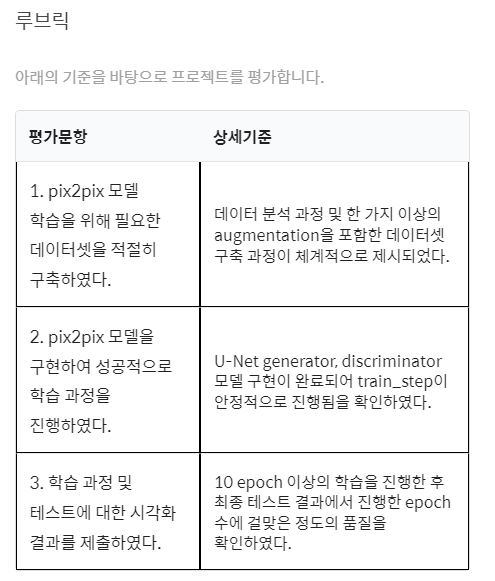

오히려 10에포크 때보다 150 에포크에서 학습이 제대로 되지 않은거 같았다...

아예 회색음영으로 나와버린건...

문제가 있을터인데, 시간관계로 당장 내일 한번더 시도를 해보고자 한다.

우선 10 에포크에서는 에포크에 걸맞는 품질이 나온거 같다.

p.s.) 재시도 해서 200에포크로 학습해보았으나 역시..주말에 시간 내어서 다시 해봐야할 것 같다.
https://blog.omnious.com/salam-nakkneun-ingongjineung-i-issda-dibpeikeu-iyagi